# Credit Classification - Sanguino Osa, Alejandro | 132515

### *He elegido la clasificación porque fue el modelo de Machine Learning que más me llamó la atención durante el curso, en este tendremos que analizar un conjunto de personas a las que se les ofreció una oferta de un crédito bancario, la variable a predecir es, en efecto, si aceptan la oferta o no.*

## Importamos las librerías que vamos a usar

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()
from collections import Counter

from scipy.special import expit

from sklearn.model_selection import train_test_split,RepeatedStratifiedKFold,cross_val_score
from sklearn import tree
from sklearn import preprocessing

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#!pip install -U imbalanced-learn
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss

from tabulate import tabulate

#Ignoraremos los warnings porque solo molestan a la presentación
np.seterr(divide='ignore', invalid='ignore')
import warnings
warnings.filterwarnings('always')

#### Importamos los datos y creamos el DataFrame.

In [3]:
url='https://drive.google.com/file/d/1rs9UcRrQhxa31YgN3BysRvms5sEixAeZ/view?usp=share_link'
file_id=url.split('/')[-2]
dwn_url='https://drive.google.com/uc?id=' + file_id
credit = pd.read_csv(dwn_url, sep = ';')
credit

,Customer_Number,Offer_Accepted,Reward,Mailer_Type,Income_Level,Bank_Accounts_Open,Overdraft_Protection,Credit_Rating,Credit_Cards_Held,Homes_Owned,Household_Size,Own_Your_Home,Average_Balance,Q1_Balance,Q2_Balance,Q3_Balance,Q4_Balance
0,1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669.0,877.0,1095.0,1002.0
1,2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39.0,106.0,78.0,366.0
2,3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367.0,352.0,145.0,242.0
3,4,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578.0,1760.0,1119.0,419.0
4,5,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140.0,1357.0,982.0,365.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,17996,No,Cash Back,Letter,High,1,No,Low,1,1,5,Yes,167.50,136.0,65.0,71.0,398.0
17996,17997,No,Cash Back,Letter,High,1,No,Low,3,1,3,Yes,850.50,984.0,940.0,943.0,535.0
17997,17998,No,Cash Back,Letter,High,1,No,Low,2,1,4,No,1087.25,918.0,767.0,1170.0,1494.0
17998,17999,No,Cash Back,Letter,Medium,1,No,Medium,4,2,2,Yes,1022.25,626.0,983.0,865.0,1615.0


## Análisis Exploratorio

In [4]:
credit.groupby('Offer_Accepted')['Offer_Accepted'].count()

Offer_Accepted
No     16977
Yes     1023
Name: Offer_Accepted, dtype: int64

### Limpieza

In [5]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Customer_Number       18000 non-null  int64  
 1   Offer_Accepted        18000 non-null  object 
 2   Reward                18000 non-null  object 
 3   Mailer_Type           18000 non-null  object 
 4   Income_Level          18000 non-null  object 
 5   Bank_Accounts_Open    18000 non-null  int64  
 6   Overdraft_Protection  18000 non-null  object 
 7   Credit_Rating         18000 non-null  object 
 8   Credit_Cards_Held     18000 non-null  int64  
 9   Homes_Owned           18000 non-null  int64  
 10  Household_Size        18000 non-null  int64  
 11  Own_Your_Home         18000 non-null  object 
 12  Average_Balance       17976 non-null  float64
 13  Q1_Balance            17976 non-null  float64
 14  Q2_Balance            17976 non-null  float64
 15  Q3_Balance         

##### Parece que tenemos algunos NaN así que vamos a limpiarlos.

In [6]:
credit = credit.drop(columns=['Q1_Balance','Q2_Balance','Q3_Balance','Q4_Balance']) 
# no los vamos a usar

In [7]:
credit['Average_Balance'] = credit['Average_Balance'].fillna(credit['Average_Balance'].mean())

In [8]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Customer_Number       18000 non-null  int64  
 1   Offer_Accepted        18000 non-null  object 
 2   Reward                18000 non-null  object 
 3   Mailer_Type           18000 non-null  object 
 4   Income_Level          18000 non-null  object 
 5   Bank_Accounts_Open    18000 non-null  int64  
 6   Overdraft_Protection  18000 non-null  object 
 7   Credit_Rating         18000 non-null  object 
 8   Credit_Cards_Held     18000 non-null  int64  
 9   Homes_Owned           18000 non-null  int64  
 10  Household_Size        18000 non-null  int64  
 11  Own_Your_Home         18000 non-null  object 
 12  Average_Balance       18000 non-null  float64
dtypes: float64(1), int64(5), object(7)
memory usage: 1.8+ MB


#### Ya no hay ningún valor perdido ni nada extraño, por lo que podemos dar la limpieza por terminada, seguimos con el análisis exploratorio.

---

In [9]:
credit.describe(percentiles = (0.1, 0.25, 0.75, 0.8, 0.9))

,Customer_Number,Bank_Accounts_Open,Credit_Cards_Held,Homes_Owned,Household_Size,Average_Balance
count,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000
mean,9000.500000,1.255778,1.903500,1.203444,3.499056,940.515562
std,5196.296758,0.472501,0.797009,0.427341,1.114182,350.064214
min,1.000000,1.000000,1.000000,1.000000,1.000000,48.250000
10%,1800.900000,1.000000,1.000000,1.000000,2.000000,288.500000
25%,4500.750000,1.000000,1.000000,1.000000,3.000000,787.937500
50%,9000.500000,1.000000,2.000000,1.000000,3.000000,1006.500000
75%,13500.250000,1.000000,2.000000,1.000000,4.000000,1152.562500
80%,14400.200000,2.000000,3.000000,1.000000,4.000000,1192.250000
90%,16200.100000,2.000000,3.000000,2.000000,5.000000,1293.000000


#### Los percentiles para variables categóricas no aportan mucha información, pero de aquí hemos encontrado una oportunidad para visualizar la relación del Average_Balance con el Income_Level.

In [90]:
credit.groupby('Income_Level')['Average_Balance'].mean()

Income_Level
High      942.570837
Low       937.668817
Medium    940.892480
Name: Average_Balance, dtype: float64

<AxesSubplot:xlabel='Income_Level', ylabel='Average_Balance'>

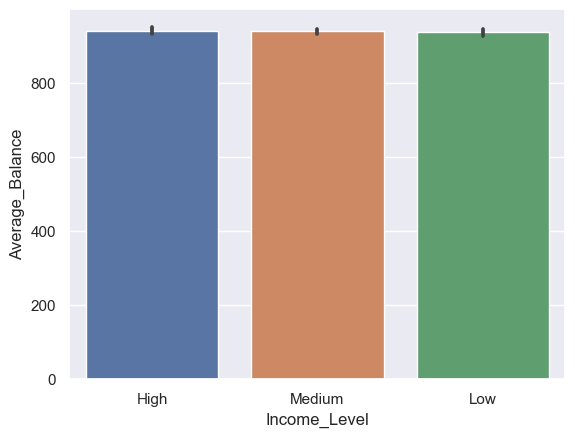

In [89]:
sns.barplot(data = credit, y='Average_Balance', x = 'Income_Level')

<AxesSubplot:ylabel='Income_Level'>

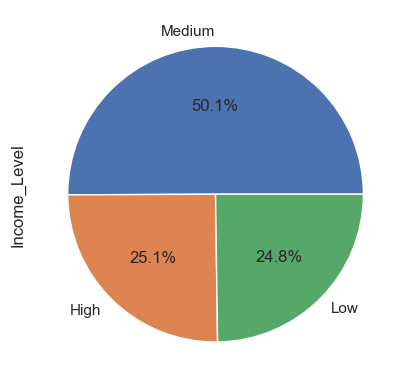

In [91]:
creditHomes = credit['Income_Level'].value_counts()
creditHomes
creditHomes.plot.pie(autopct="%.1f%%")

<AxesSubplot:ylabel='Homes_Owned'>

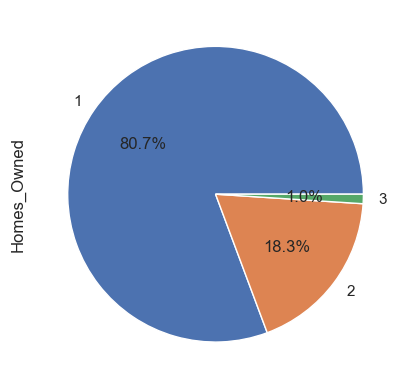

In [10]:
creditHomes = credit['Homes_Owned'].value_counts()
creditHomes
creditHomes.plot.pie(autopct="%.1f%%")

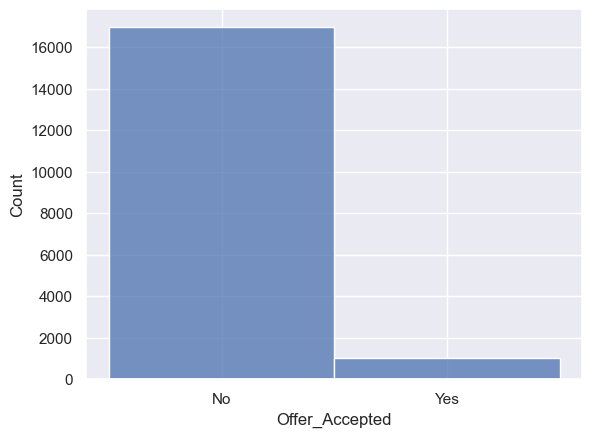

In [11]:
sns.histplot(credit['Offer_Accepted']);

<AxesSubplot:xlabel='Bank_Accounts_Open', ylabel='Count'>

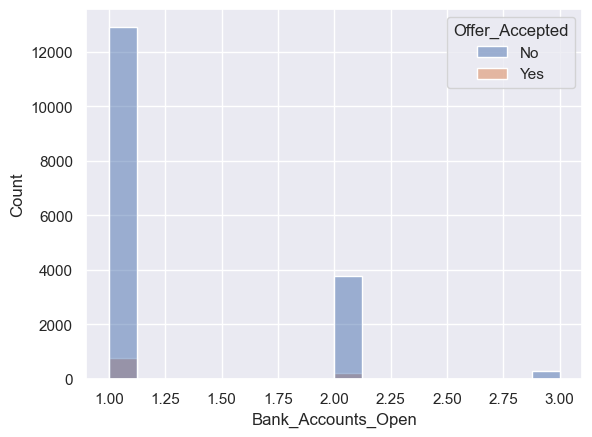

In [12]:
sns.histplot(data = credit, x='Bank_Accounts_Open', hue = 'Offer_Accepted')

<AxesSubplot:xlabel='Overdraft_Protection', ylabel='Count'>

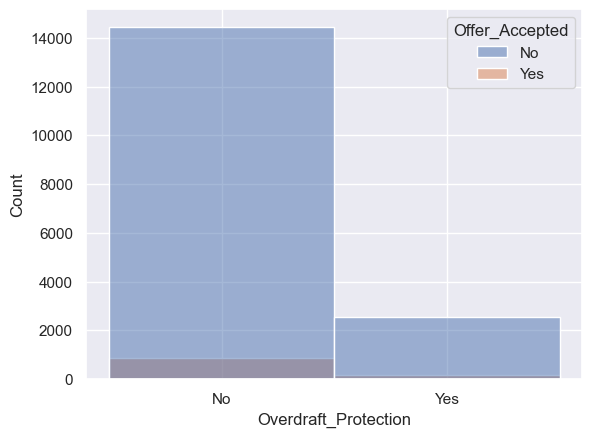

In [13]:
sns.histplot(data = credit, x='Overdraft_Protection', hue = 'Offer_Accepted') 

<AxesSubplot:xlabel='Own_Your_Home', ylabel='Count'>

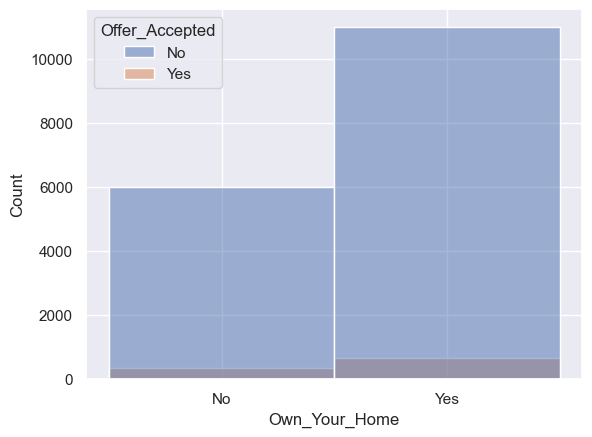

In [14]:
sns.histplot(data = credit, x='Own_Your_Home', hue = 'Offer_Accepted') 

<AxesSubplot:xlabel='Reward', ylabel='Count'>

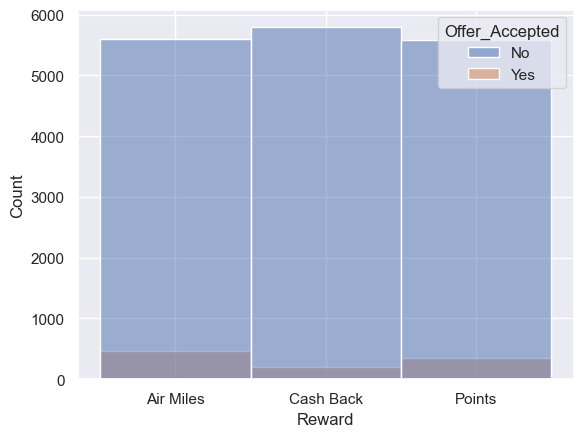

In [15]:
sns.histplot(data = credit, x='Reward', hue = 'Offer_Accepted') 

<AxesSubplot:xlabel='Credit_Rating', ylabel='Count'>

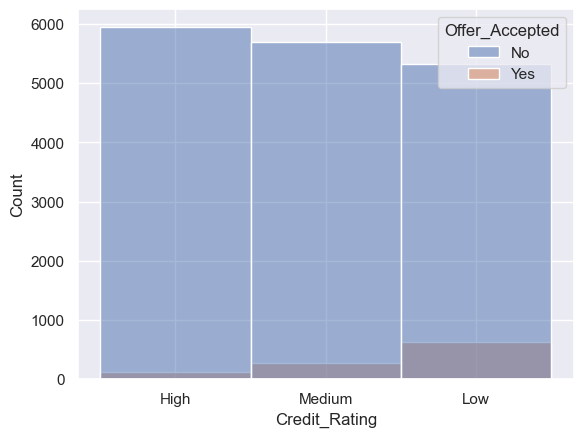

In [16]:
sns.histplot(data = credit, x='Credit_Rating', hue = 'Offer_Accepted')

<AxesSubplot:xlabel='Mailer_Type', ylabel='Count'>

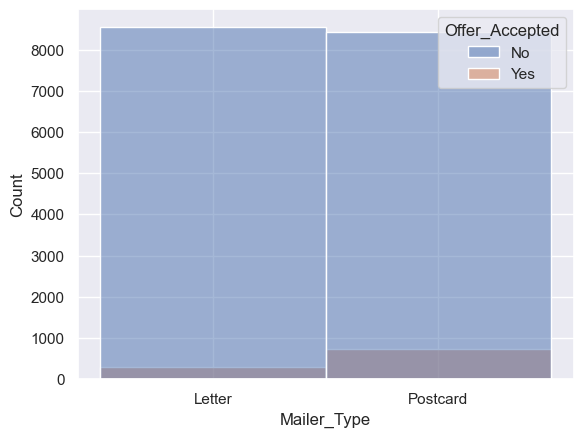

In [17]:
sns.histplot(data = credit, x='Mailer_Type', hue = 'Offer_Accepted')

<AxesSubplot:xlabel='Income_Level', ylabel='Count'>

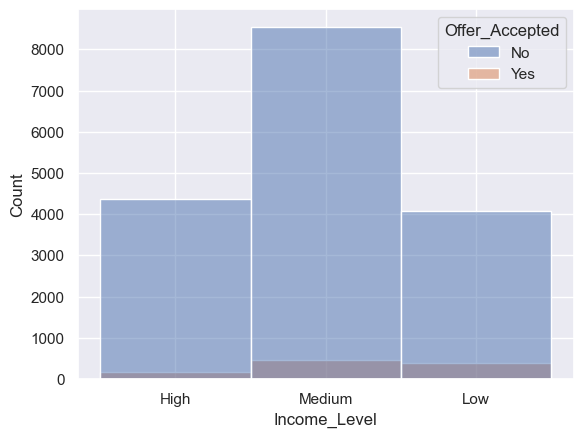

In [18]:
sns.histplot(data = credit, x='Income_Level', hue = 'Offer_Accepted')

#### No se ve muy bien con las gráficas tan desproporcionadas así que vamos a probar nuestra hipótesis de que los menos adinerados son los que más aceptan.

In [19]:
pd.pivot_table(credit[['Offer_Accepted','Income_Level','Homes_Owned']], index='Offer_Accepted', columns='Income_Level', aggfunc='count').fillna(0)

Homes_Owned             
Income_Level          High   Low Medium
Offer_Accepted                         
No                    4361  4073   8543
Yes                    165   388    470

In [20]:
pd.pivot_table(credit[['Offer_Accepted','Income_Level','Bank_Accounts_Open']], index='Offer_Accepted', columns='Bank_Accounts_Open', aggfunc='count')

Income_Level           
Bank_Accounts_Open            1     2    3
Offer_Accepted                            
No                        12916  3778  283
Yes                         776   234   13

##### Muy mal balanceado, vamos a hacer uso de las librerías de imbalanced en el conjunto de entrenamiento más adelante para tener unos datos equilibrados, si no el modelo tendría mucho error.

---

### Ahora vamos a ver qué parámetros vamos a usar para la Clasificación

In [21]:
credit[credit['Offer_Accepted']=='Yes']

,Customer_Number,Offer_Accepted,Reward,Mailer_Type,Income_Level,Bank_Accounts_Open,Overdraft_Protection,Credit_Rating,Credit_Cards_Held,Homes_Owned,Household_Size,Own_Your_Home,Average_Balance
27,28,Yes,Air Miles,Letter,Medium,1,No,Low,1,1,2,No,769.50
45,46,Yes,Air Miles,Postcard,High,1,Yes,Low,2,1,5,Yes,851.25
50,51,Yes,Air Miles,Postcard,Low,1,No,High,2,1,2,Yes,931.75
57,58,Yes,Air Miles,Postcard,Low,1,No,Medium,1,1,2,Yes,1192.75
74,75,Yes,Cash Back,Postcard,High,1,No,Low,2,2,5,Yes,1329.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17940,17941,Yes,Air Miles,Postcard,Medium,1,Yes,Low,2,1,4,Yes,1140.25
17942,17943,Yes,Air Miles,Postcard,Low,1,No,Medium,1,1,3,Yes,1026.25
17971,17972,Yes,Cash Back,Postcard,Low,1,No,High,2,2,4,Yes,1221.75
17984,17985,Yes,Points,Postcard,High,1,No,Low,2,1,2,No,977.25


In [22]:
# Veo las que comparten un patrón a la hora de aceptar la oferta.
print(credit['Offer_Accepted'].unique())
print(credit['Income_Level'].unique())
print(credit['Mailer_Type'].unique())
print(credit['Reward'].unique())
print(credit['Credit_Rating'].unique())
print(credit['Own_Your_Home'].unique())
print(credit['Overdraft_Protection'].unique())
print(credit['Bank_Accounts_Open'].unique())

['No' 'Yes']
['High' 'Medium' 'Low']
['Letter' 'Postcard']
['Air Miles' 'Cash Back' 'Points']
['High' 'Medium' 'Low']
['No' 'Yes']
['No' 'Yes']
[1 2 3]


In [23]:
scaler = StandardScaler()
minmax = MinMaxScaler()
credit['Average_Balance_st'] = scaler.fit_transform(credit[['Average_Balance']])
credit['Average_Balance_MM'] = minmax.fit_transform(credit[['Average_Balance']])
credit

,Customer_Number,Offer_Accepted,Reward,Mailer_Type,Income_Level,Bank_Accounts_Open,Overdraft_Protection,Credit_Rating,Credit_Cards_Held,Homes_Owned,Household_Size,Own_Your_Home,Average_Balance,Average_Balance_st,Average_Balance_MM
0,1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,0.629143,0.335292
1,2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,-2.266120,0.029837
2,3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,-1.896892,0.068791
3,4,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,0.795546,0.352848
4,5,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,0.772692,0.350437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,17996,No,Cash Back,Letter,High,1,No,Low,1,1,5,Yes,167.50,-2.208272,0.035940
17996,17997,No,Cash Back,Letter,High,1,No,Low,3,1,3,Yes,850.50,-0.257147,0.241787
17997,17998,No,Cash Back,Letter,High,1,No,Low,2,1,4,No,1087.25,0.419176,0.313140
17998,17999,No,Cash Back,Letter,Medium,1,No,Medium,4,2,2,Yes,1022.25,0.233491,0.293550


#### Usamos .LabelEncoder() para convertir en el tipo de variable adecuado para que funcione la función dummy

In [24]:
credit['Bank_Accounts_Open'] = credit['Bank_Accounts_Open'].astype('str')

In [25]:
label_encoder = preprocessing.LabelEncoder()

### Convertimos las variables en dummies para conseguir una mejor clasificación

In [26]:
credit_dum = pd.get_dummies(credit[['Income_Level','Mailer_Type','Reward','Credit_Rating','Own_Your_Home','Overdraft_Protection','Bank_Accounts_Open']])
credit_dum['Offer_Accepted']= label_encoder.fit_transform(credit['Offer_Accepted'])
credit_dum['Average_Balance_MM'] = credit['Average_Balance_MM']
credit_dum

,Income_Level_High,Income_Level_Low,Income_Level_Medium,Mailer_Type_Letter,Mailer_Type_Postcard,Reward_Air Miles,Reward_Cash Back,Reward_Points,Credit_Rating_High,Credit_Rating_Low,Credit_Rating_Medium,Own_Your_Home_No,Own_Your_Home_Yes,Overdraft_Protection_No,Overdraft_Protection_Yes,Bank_Accounts_Open_1,Bank_Accounts_Open_2,Bank_Accounts_Open_3,Offer_Accepted,Average_Balance_MM
0,1,0,0,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0.335292
1,0,0,1,1,0,1,0,0,0,0,1,0,1,1,0,1,0,0,0,0.029837
2,1,0,0,0,1,1,0,0,0,0,1,0,1,1,0,0,1,0,0,0.068791
3,0,0,1,1,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0.352848
4,0,0,1,1,0,1,0,0,0,0,1,0,1,1,0,1,0,0,0,0.350437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0,0,0,0.035940
17996,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0,0,0,0.241787
17997,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,0,0,0.313140
17998,0,0,1,1,0,0,1,0,0,0,1,0,1,1,0,1,0,0,0,0.293550


In [27]:
#Vamos a dejar algunas opciones fuera de la prueba pues por ejemplo, si tenemos tres tipos de Income; bajo medio y alto, solo necesitamos dos, pues el otro se asume, y así.
X = credit_dum.drop(columns=['Income_Level_High','Mailer_Type_Letter','Reward_Air Miles','Credit_Rating_High','Own_Your_Home_No','Overdraft_Protection_No','Bank_Accounts_Open_3','Offer_Accepted'])
y = credit_dum['Offer_Accepted']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=42)

#### Equilibramos el conjunto de Train

In [29]:
# Vamos a probar el over sampling.

In [30]:
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros= ros.fit_resample(X_train, y_train)

In [31]:
y_train_ros.value_counts()

0    13590
1    13590
Name: Offer_Accepted, dtype: int64

<AxesSubplot:xlabel='Offer_Accepted', ylabel='Count'>

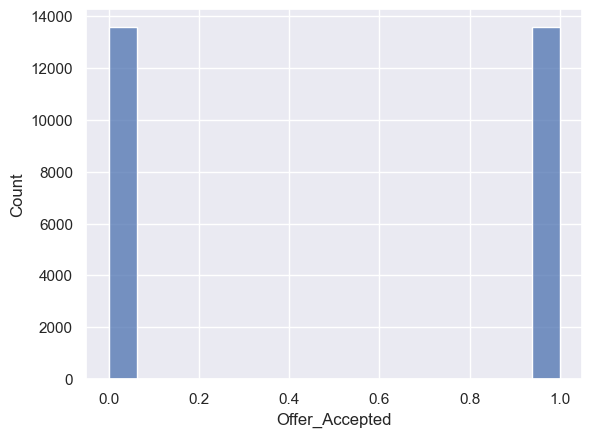

In [32]:
sns.histplot(y_train_ros)

#### Aunque tengamos los valores ya equilibrados vamos a probar sin balancear

In [33]:
model_LR = LogisticRegression()
model_LR.fit(X_train, y_train)

print(model_LR.intercept_)
print(model_LR.coef_)

[-4.9986842]
[[ 0.96656094  0.38317799  0.89417468 -0.88338586 -0.25482653  1.73109402
   0.80021277  0.06876725 -0.17595005  0.40803887  0.41341419  0.04660707]]


In [34]:
# Probamos sin equilibrar

print("Train set score (Accuracy) =", model_LR.score(X_train, y_train).round(4))
print("Test set score (Accuracy) =", model_LR.score(X_test, y_test).round(4))

conf_mat = confusion_matrix(y_test, model_LR.predict(X_test))
print(tabulate(conf_mat,headers = ['pred Offer_Accepted No','pred Offer_Accepted Yes'], showindex = ['real Offer_Accepted No','real Offer_Accepted Yes'], tablefmt = 'fancy_grid'))

print(classification_report(y_test, model_LR.predict(X_test)))

Train set score (Accuracy) = 0.9438
Test set score (Accuracy) = 0.9408
╒═════════════════════════╤══════════════════════════╤═══════════════════════════╕
│                         │   pred Offer_Accepted No │   pred Offer_Accepted Yes │
╞═════════════════════════╪══════════════════════════╪═══════════════════════════╡
│ real Offer_Accepted No  │                     3387 │                         0 │
├─────────────────────────┼──────────────────────────┼───────────────────────────┤
│ real Offer_Accepted Yes │                      213 │                         0 │
╘═════════════════════════╧══════════════════════════╧═══════════════════════════╛
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      3387
           1       0.00      0.00      0.00       213

    accuracy                           0.94      3600
   macro avg       0.47      0.50      0.48      3600
weighted avg       0.89      0.94      0.91      3600



C:\Users\sangu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sangu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sangu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Da un error de cálculo por tener los grupos tan desequilibrados, por ello no se tendrá en cuenta.

#### Ahora vamos a hacerlo bien, equilibrándolo con el oversampling que hicimos antes

In [36]:
# Y ahora equilibrado con oversampling, alcanzando mejor accuracy

model_LR_ros = LogisticRegression()
model_LR_ros.fit(X_train_ros, y_train_ros)

print(model_LR_ros.intercept_)
print(model_LR_ros.coef_)
print('############')
print("Train set score (Accuracy) =", model_LR_ros.score(X_train_ros, y_train_ros).round(4))
print("Test set score (Accuracy) =", model_LR_ros.score(X_test, y_test).round(4))

conf_mat = confusion_matrix(y_test, model_LR_ros.predict(X_test))
print(tabulate(conf_mat,headers = ['pred Offer_Accepted No','pred Offer_Accepted Yes'], showindex = ['real Offer_Accepted No','real Offer_Accepted Yes'], tablefmt = 'fancy_grid'))

print(classification_report(y_test, model_LR_ros.predict(X_test)))

[-2.21436224]
[[ 1.02193835  0.40718188  0.9428911  -1.10342038 -0.30880051  1.84605425
   0.84501419  0.08463153 -0.15202231  0.41569623  0.45716165 -0.13252681]]
############
Train set score (Accuracy) = 0.6923
Test set score (Accuracy) = 0.6628
╒═════════════════════════╤══════════════════════════╤═══════════════════════════╕
│                         │   pred Offer_Accepted No │   pred Offer_Accepted Yes │
╞═════════════════════════╪══════════════════════════╪═══════════════════════════╡
│ real Offer_Accepted No  │                     2230 │                      1157 │
├─────────────────────────┼──────────────────────────┼───────────────────────────┤
│ real Offer_Accepted Yes │                       57 │                       156 │
╘═════════════════════════╧══════════════════════════╧═══════════════════════════╛
              precision    recall  f1-score   support

           0       0.98      0.66      0.79      3387
           1       0.12      0.73      0.20       213

    acc

### Vamos a probar el RandomForest después de ver la regresión logística

In [37]:
rf_clf = RandomForestClassifier(n_estimators = 3, criterion ='gini') #  criterion ='entropy' 
rf_clf.fit(X_train_ros,y_train_ros)

RandomForestClassifier(n_estimators=3)

In [38]:
y_predict = rf_clf.predict(X_test)

In [39]:
print("Train set score (Accuracy) =", rf_clf.score(X_train, y_train).round(4))
print("Test set score (Accuracy) =", rf_clf.score(X_test, y_test).round(4))

conf_mat = confusion_matrix(y_test, rf_clf.predict(X_test))
print(tabulate(conf_mat,headers = ['pred Offer_Accepted No','pred Offer_Accepted Yes'], showindex = ['real Offer_Accepted No','real Offer_Accepted Yes'], tablefmt = 'fancy_grid'))

print(classification_report(y_test, rf_clf.predict(X_test)))

Train set score (Accuracy) = 0.9856
Test set score (Accuracy) = 0.8892
╒═════════════════════════╤══════════════════════════╤═══════════════════════════╕
│                         │   pred Offer_Accepted No │   pred Offer_Accepted Yes │
╞═════════════════════════╪══════════════════════════╪═══════════════════════════╡
│ real Offer_Accepted No  │                     3179 │                       208 │
├─────────────────────────┼──────────────────────────┼───────────────────────────┤
│ real Offer_Accepted Yes │                      191 │                        22 │
╘═════════════════════════╧══════════════════════════╧═══════════════════════════╛
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      3387
           1       0.10      0.10      0.10       213

    accuracy                           0.89      3600
   macro avg       0.52      0.52      0.52      3600
weighted avg       0.89      0.89      0.89      3600



#### Vemos que es mucho mejor el Random Forest pero quizás no sea la más indicada para nuestro objetivo

---

## Vamos a hacer un undersampling y ver si mejora el asunto

In [42]:
# Randomly under sample the majority class
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus= rus.fit_resample(X_train, y_train)

# Check the number of records after under sampling
print(sorted(Counter(y_train_rus).items()))

[(0, 810), (1, 810)]


<AxesSubplot:xlabel='Offer_Accepted', ylabel='Count'>

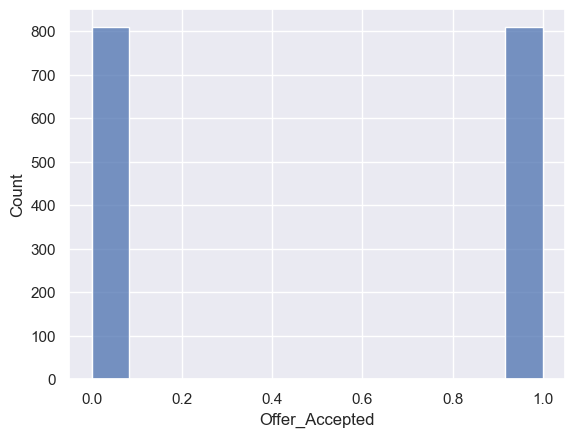

In [61]:
sns.histplot(y_train_rus)

#### Regresión Logística

In [43]:
model_LR_rus = LogisticRegression()
model_LR_rus.fit(X_train_rus, y_train_rus)

LogisticRegression()

In [44]:
print("Train set score (Accuracy) =", model_LR_rus.score(X_train_rus, y_train_rus).round(4))
print("Test set score (Accuracy) =", model_LR_rus.score(X_test, y_test).round(4))

conf_mat = confusion_matrix(y_test, model_LR_rus.predict(X_test))
print(tabulate(conf_mat,headers = ['pred diagnosis B','pred diagnosis M'], showindex = ['real iagnosis B','real diagnosis M'], tablefmt = 'fancy_grid'))

print(classification_report(y_test, model_LR_rus.predict(X_test)))

Train set score (Accuracy) = 0.6932
Test set score (Accuracy) = 0.6714
╒══════════════════╤════════════════════╤════════════════════╕
│                  │   pred diagnosis B │   pred diagnosis M │
╞══════════════════╪════════════════════╪════════════════════╡
│ real iagnosis B  │               2267 │               1120 │
├──────────────────┼────────────────────┼────────────────────┤
│ real diagnosis M │                 63 │                150 │
╘══════════════════╧════════════════════╧════════════════════╛
              precision    recall  f1-score   support

           0       0.97      0.67      0.79      3387
           1       0.12      0.70      0.20       213

    accuracy                           0.67      3600
   macro avg       0.55      0.69      0.50      3600
weighted avg       0.92      0.67      0.76      3600



In [77]:
rf_clf = RandomForestClassifier(n_estimators = 3, criterion ='gini') #  criterion ='entropy' 
rf_clf.fit(X_train_ros,y_train_ros)
y_predict = rf_clf.predict(X_test)
print("Train set score (Accuracy) =", rf_clf.score(X_train_rus, y_train_rus).round(4))
print("Test set score (Accuracy) =", rf_clf.score(X_test, y_test).round(4))

conf_mat = confusion_matrix(y_test, rf_clf.predict(X_test))
print(tabulate(conf_mat,headers = ['pred Offer_Accepted No','pred Offer_Accepted Yes'], showindex = ['real Offer_Accepted No','real Offer_Accepted Yes'], tablefmt = 'fancy_grid'))

print(classification_report(y_test, rf_clf.predict(X_test)))

Train set score (Accuracy) = 0.9926
Test set score (Accuracy) = 0.8867
╒═════════════════════════╤══════════════════════════╤═══════════════════════════╕
│                         │   pred Offer_Accepted No │   pred Offer_Accepted Yes │
╞═════════════════════════╪══════════════════════════╪═══════════════════════════╡
│ real Offer_Accepted No  │                     3164 │                       223 │
├─────────────────────────┼──────────────────────────┼───────────────────────────┤
│ real Offer_Accepted Yes │                      185 │                        28 │
╘═════════════════════════╧══════════════════════════╧═══════════════════════════╛
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      3387
           1       0.11      0.13      0.12       213

    accuracy                           0.89      3600
   macro avg       0.53      0.53      0.53      3600
weighted avg       0.90      0.89      0.89      3600



### Finalmente probaremos con el SMOTE

In [46]:
smote = SMOTE()

In [47]:
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

<AxesSubplot:xlabel='Offer_Accepted', ylabel='Count'>

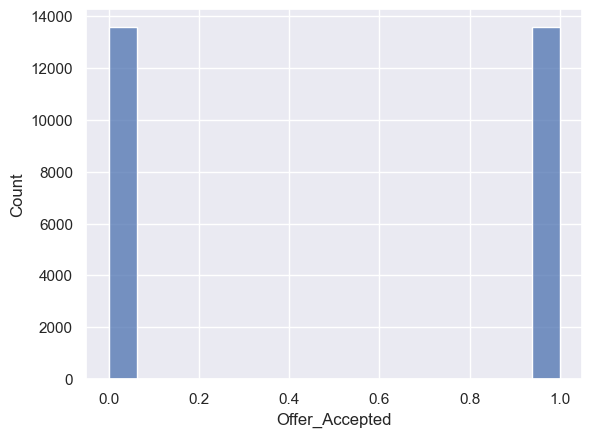

In [62]:
sns.histplot(y_train_sm)

In [48]:
model_LR_sm = LogisticRegression()
model_LR_sm.fit(X_train_sm, y_train_sm)

LogisticRegression()

In [49]:
print("Train set score (Accuracy) =", model_LR_sm.score(X_train_sm, y_train_sm).round(4))
print("Test set score (Accuracy) =", model_LR_sm.score(X_test, y_test).round(4))

conf_mat = confusion_matrix(y_test, model_LR_sm.predict(X_test))
print(tabulate(conf_mat, headers = ['pred diagnosis B','pred diagnosis M'], showindex = ['real diagnosis B','real diagnosis M'], tablefmt = 'fancy_grid'))

print(classification_report(y_test, model_LR_sm.predict(X_test)))

Train set score (Accuracy) = 0.6983
Test set score (Accuracy) = 0.6906
╒══════════════════╤════════════════════╤════════════════════╕
│                  │   pred diagnosis B │   pred diagnosis M │
╞══════════════════╪════════════════════╪════════════════════╡
│ real diagnosis B │               2340 │               1047 │
├──────────────────┼────────────────────┼────────────────────┤
│ real diagnosis M │                 67 │                146 │
╘══════════════════╧════════════════════╧════════════════════╛
              precision    recall  f1-score   support

           0       0.97      0.69      0.81      3387
           1       0.12      0.69      0.21       213

    accuracy                           0.69      3600
   macro avg       0.55      0.69      0.51      3600
weighted avg       0.92      0.69      0.77      3600



In [50]:
rf_clf = RandomForestClassifier(n_estimators = 3, criterion ='gini') #  criterion ='entropy' 
rf_clf.fit(X_train_sm,y_train_sm)
y_predict = rf_clf.predict(X_test)
print("Train set score (Accuracy) =", rf_clf.score(X_train_sm, y_train_sm).round(4))
print("Test set score (Accuracy) =", rf_clf.score(X_test, y_test).round(4))

conf_mat = confusion_matrix(y_test, rf_clf.predict(X_test))
print(tabulate(conf_mat,headers = ['pred Offer_Accepted No','pred Offer_Accepted Yes'], showindex = ['real Offer_Accepted No','real Offer_Accepted Yes'], tablefmt = 'fancy_grid'))

print(classification_report(y_test, rf_clf.predict(X_test)))

Train set score (Accuracy) = 0.9444
Test set score (Accuracy) = 0.7361
╒═════════════════════════╤══════════════════════════╤═══════════════════════════╕
│                         │   pred Offer_Accepted No │   pred Offer_Accepted Yes │
╞═════════════════════════╪══════════════════════════╪═══════════════════════════╡
│ real Offer_Accepted No  │                     2557 │                       830 │
├─────────────────────────┼──────────────────────────┼───────────────────────────┤
│ real Offer_Accepted Yes │                      120 │                        93 │
╘═════════════════════════╧══════════════════════════╧═══════════════════════════╛
              precision    recall  f1-score   support

           0       0.96      0.75      0.84      3387
           1       0.10      0.44      0.16       213

    accuracy                           0.74      3600
   macro avg       0.53      0.60      0.50      3600
weighted avg       0.90      0.74      0.80      3600



### Tendremos que evaluar cuál es el modelo que más nos aporta, pues aunque el RandomForest con UnderSampling tiene los mejores valores ha dejado fuera a muchos clientes potenciales y el pred-real offer accepted es muy bajo, que son los clientes que realmente han aceptado la oferta, y eso no nos conviene.

# Entonces nos quedaremos con la Regresión Logística con OverSampling, pues, aparte del mayor número de aciertos tiene el mejor precisión y la mejor recall.

---

## Curva ROC

Logistic: ROC AUC=0.767


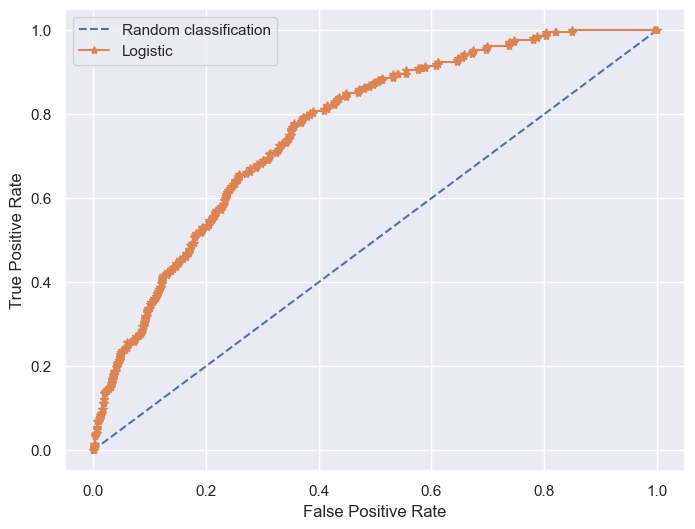

In [78]:
prob_test = pd.DataFrame(model_LR_ros.predict_proba(X_test))
prob_test = prob_test[1]

# generate a no skill prediction (majority class)
random_class = [0 for _ in range(len(y_test))]
rand_auc = roc_auc_score(y_test, random_class)

auc = roc_auc_score(y_test, prob_test)
print('Logistic: ROC AUC=%.3f' % (auc))

rndm_false_postv, rndm_true_postv, threshold = roc_curve(y_test, random_class)
false_positive, true_postitive, _ = roc_curve(y_test, prob_test)

plt.figure(figsize=(8, 6))
plt.plot(rndm_false_postv, rndm_true_postv, linestyle='--', label='Random classification')
plt.plot(false_positive, true_postitive, marker='*', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

#### Con la curva de ROC reforzamos la conclusión de que tenemos una buena clasificación pues nos queda un AUC cerca de 1

In [85]:
def Threshold(X = X_test, model = model_LR_ros, threshold = 0.5):
    prob_test = pd.DataFrame(model.predict_proba(X).round(3))
    
    prob_test.loc[prob_test[1] > threshold, 'yhat'] = 1
    prob_test.loc[prob_test[1] <= threshold, 'yhat'] = 0
    
    y_threshold = pd.concat([prob_test, y_test.reset_index(drop = True)], axis = 1)
    cross_threshold = pd.crosstab(y_threshold["Offer_Accepted"], y_threshold["yhat"], margins = True)
    
    print(tabulate(cross_threshold,headers = ['pred Offer_Accepted No','Pred Offer_Accepted Yes', 'All'], showindex = ['Real Offer_Accepted No','Real Offer_Accepted Yes', 'All'], tablefmt = 'fancy_grid'))
    
    accuracy = (cross_threshold[1][1] + cross_threshold[0][0]) / (cross_threshold['All']['All'])
    recall = cross_threshold[1][1] / (cross_threshold[1][1] + cross_threshold[0][1])
    precision = cross_threshold[1][1] / (cross_threshold[1][1] + cross_threshold[1][0])
    F_Score = 2*(precision*recall) / (precision + recall)
    print("\n")
    print("Accuracy", accuracy.round(3))
    print("Precision", precision.round(3))
    print("Recall", recall.round(3))
    print("F_Score", F_Score.round(3))
    print("\n")
    #return cross_threshold

Threshold(X_test,model_LR_ros, 0.64)

╒═════════════════════════╤══════════════════════════╤═══════════════════════════╤═══════╕
│                         │   pred Offer_Accepted No │   Pred Offer_Accepted Yes │   All │
╞═════════════════════════╪══════════════════════════╪═══════════════════════════╪═══════╡
│ Real Offer_Accepted No  │                     2826 │                       561 │  3387 │
├─────────────────────────┼──────────────────────────┼───────────────────────────┼───────┤
│ Real Offer_Accepted Yes │                      113 │                       100 │   213 │
├─────────────────────────┼──────────────────────────┼───────────────────────────┼───────┤
│ All                     │                     2939 │                       661 │  3600 │
╘═════════════════════════╧══════════════════════════╧═══════════════════════════╧═══════╛


Accuracy 0.813
Precision 0.151
Recall 0.469
F_Score 0.229




---

## Conclusión

### *Quizás no parezcan los mejores resultados a simple vista, pero después de optimizarlo llegamos a que de 561 personas a las que les enviamos la oferta, conseguimos 100 clientes, lo cual nos deja con una tasa de conversión del 15,6%, lo cual, tanto económica como empresarialmente, es algo muy bueno, pues las tasas de conversión ( cuanta gente de todos a los que se lo muestras realmente entre en tu propuesta de negocio ) suelen estar en torno al 3%, así que, desde el punto de vista de la empresa que trata con esta oferta de crédito, este modelo supondrá un gran optimización de su campaña y su dinero.*


---